# Models with Multiple Source Populations

*ARES* can handle an arbitrary number of source populations. To
access this functionality, create a dictionary representing each source
population of interest. Below, we'll create a population representative of PopII stars and another representative of PopIII stars.

Before we start, it is important to note that in *ARES*, source populations are identified by their spectra over some contiguous interval in photon energy. This can be somewhat counterintuitive. For example, though UV emission from stars and X-ray emission from their compact remnants, e.g., X-ray binary systems, are both natural byproducts of star formation, we treat them as separate source populations in *ARES* even though the emission from each type of source is related to the same rate of star formation. However, because stars and XRBs have very different spectra, whose normalizations are parameterized differently, it is more convenient in the code to keep them separate. Because of this, what you might think of as a single source population (stars and their remnants) actually constitutes *two* source populations in *ARES*. 

Let's start with a PopII source population, and a few standard imports:

In [1]:
%pylab inline
import ares
import numpy as np
import matplotlib.pyplot as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
pars = \
{
 'problem_type': 100,              # Blank slate global 21-cm signal


 # Setup star formation
 'pop_Tmin{0}': 1e4,               # atomic cooling halos
 'pop_fstar{0}': 1e-1,             # 10% star formation efficiency
 
 # Setup UV emission
 'pop_sed_model{0}': True,
 'pop_sed{0}': 'bb',               # PopII stars -> 10^4 K blackbodies
 'pop_temperature{0}': 1e4,
 'pop_rad_yield{0}': 1e42,
 'pop_fesc{0}': 0.2,
 'pop_Emin{0}': 10.19, 
 'pop_Emax{0}': 24.6,
 'pop_EminNorm{0}': 13.6,
 'pop_EmaxNorm{0}': 24.6,
 'pop_lya_src{0}': True,
 'pop_ion_src_cgm{0}': True,
 'pop_heat_src_igm{0}': False,
 
 # Setup X-ray emission
 'pop_sed{1}': 'pl',
 'pop_alpha{1}': -1.5, 
 'pop_rad_yield{1}': 2.6e38,
 'pop_Emin{1}': 2e2, 
 'pop_Emax{1}': 3e4,
 'pop_EminNorm{1}': 5e2,
 'pop_EmaxNorm{1}': 8e3,
 
 'pop_lya_src{1}': False,
 'pop_ion_src_cgm{1}': False,
 'pop_heat_src_igm{1}': True,
 
 'pop_sfr_model{1}': 'link:sfrd:0',
}

**NOTE:** See [problem_types](../problem_types.html) for more information about why we chose ``problem_type=100`` here.   

We might as well go ahead and run this to establish a baseline:

# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.

############################################################################
##                       ARES Simulation: Overview                        ##
############################################################################
## ---------------------------------------------------------------------- ##
## Source Populations                                                     ##
## ---------------------------------------------------------------------- ##
##           sfrd    sed  radio  O/IR  Lya    LW   LyC   Xray  RTE        ##
## pop #0 :  fcoll    yes    -     -     x     x     x     -              ##
## pop #1 : sfrd->0   yes    -     -     -     -     -     x              ##
## ---------------------------------------------------------------------- ##
## Physics                                                                ##
## ---------------------------------------------------------------------- ##
## cgm_i

gs-21cm: 100% |#############################################| Time:  0:00:04 


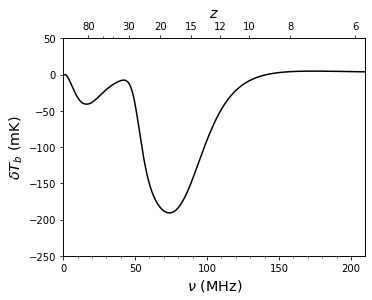

In [3]:
sim = ares.simulations.Global21cm(**pars)
sim.run()
    
ax, zax = sim.GlobalSignature(color='k')

Now, let's add a PopIII-like source population. We'll assume that PopIII sources are brighter on average (in both the UV and X-ray) but live in lower mass halos. We could just copy-pase the dictionary above, change the population ID numbers and, for example, the UV and X-ray ``pop_rad_yield`` parameters. Or, we could use some built-in tricks to speed this up.

First, let's take the PopII parameter set and make a ``ParameterBundle`` object:

In [4]:
popII = ares.util.ParameterBundle(**pars)

This let's us easily extract parameters according to their ID number, and assign new ones

In [5]:
popIII_uv = popII.pars_by_pop(0, True)
popIII_uv.num = 2
popIII_xr = popII.pars_by_pop(1, True)
popIII_xr.num = 3

The second argument tells *ARES* to remove the parameter ID numbers.

Now, we can simply reset the ID numbers and update a few important parameters:

In [6]:
popIII_uv['pop_Tmin{2}'] = 300
popIII_uv['pop_Tmax{2}'] = 1e4
popIII_uv['pop_temperature{2}'] = 1e5
popIII_uv['pop_fstar{2}'] = 1e-4
    
popIII_xr['pop_sfr_model{3}'] = 'link:sfrd:2'
popIII_xr['pop_rad_yield{3}'] = 2.6e39

Now, let's make the final parameter dictionary and run it:    

# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.

############################################################################
##                       ARES Simulation: Overview                        ##
############################################################################
## ---------------------------------------------------------------------- ##
## Source Populations                                                     ##
## ---------------------------------------------------------------------- ##
##           sfrd    sed  radio  O/IR  Lya    LW   LyC   Xray  RTE        ##
## pop #0 :  fcoll    yes    -     -     x     x     x     -              ##
## pop #1 : sfrd->0   yes    -     -     -     -     -     x              ##
## pop #2 :  fcoll    yes    -     -     x     x     x     -              ##
## pop #3 : sfrd->2   yes    -     -     -     -     -     x              ##
## ---------------------------------------------------------------------- ##
## Physi

gs-21cm: 100% |#############################################| Time:  0:00:04 


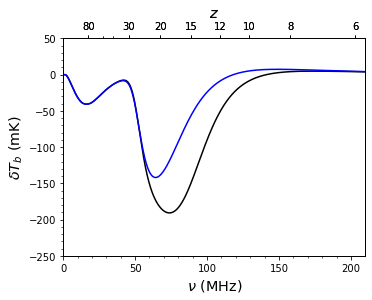

In [7]:
pars.update(popIII_uv)
pars.update(popIII_xr)
    
sim2 = ares.simulations.Global21cm(**pars)
sim2.run()

ax, zax = sim.GlobalSignature(color='k')
ax, zax = sim2.GlobalSignature(color='b', ax=ax)

Note that the parameter file hangs onto the parameters of each population separately. To verify a few key changes, you could do:  

In [8]:
len(sim2.pf.pfs)

4

In [9]:
for key in ['pop_Tmin', 'pop_fstar', 'pop_rad_yield']:
    print(key, sim2.pf.pfs[0][key], sim2.pf.pfs[2][key])

pop_Tmin 10000.0 300
pop_fstar 0.1 0.0001
pop_rad_yield 1e+42 1e+42


**NOTE:** These are very simple models for PopII and PopIII stars. For more sophisticated approaches, see [More Realistic Galaxy Populations](example_pop_galaxy) and [Including Population III Stars](example_pop_popIII).    
